In [2]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 6.2MB/s 
     |████████████████████████████████| 8.7MB 32.4MB/s 
     |████████████████████████████████| 2.1MB 39.0MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: Cython 0.29.18
    Uninstalling Cython-0.29.18:
      Successfully uninstalled Cython-0.29.18


In [0]:
import time
import warnings
import numpy as np
import pandas as pd 
import seaborn as sns 
import lightgbm as lgb
from itertools import cycle
from sklearn.svm import SVR
import statsmodels.api as sm
from pmdarima import auto_arima
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing

%matplotlib inline 
plt.style.use('bmh')
sns.set_style("whitegrid")
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
warnings.filterwarnings("ignore")
pd.set_option('max_colwidth', 100)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

In [2]:
data = pd.read_csv('/content/drive/My Drive/projects/M5 forecasting/combined data_final.csv')
data['date'] = pd.to_datetime(data['date'])
data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,demand,date,sell_price,year,month,dayofweek
0,FOODS_3_586_TX_2_validation,FOODS_3_586,FOODS_3,FOODS,TX_2,TX,98,2011-01-29,1.48,2011,1,5
1,FOODS_3_586_TX_2_validation,FOODS_3_586,FOODS_3,FOODS,TX_2,TX,85,2011-01-30,1.48,2011,1,6
2,FOODS_3_586_TX_2_validation,FOODS_3_586,FOODS_3,FOODS,TX_2,TX,47,2011-01-31,1.48,2011,1,0
3,FOODS_3_586_TX_2_validation,FOODS_3_586,FOODS_3,FOODS,TX_2,TX,56,2011-01-02,1.48,2011,2,1
4,FOODS_3_586_TX_2_validation,FOODS_3_586,FOODS_3,FOODS,TX_2,TX,51,2011-02-02,1.48,2011,2,2


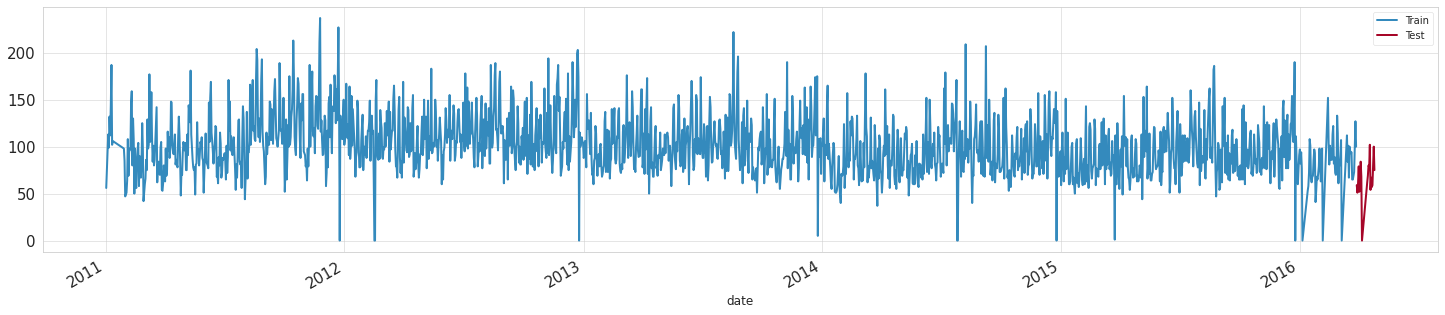

In [3]:
train = data[data['date'] <= '2016-03-27']
test = data[(data['date'] > '2016-03-27') & (data['date'] <= '2016-04-24')]

fig, ax = plt.subplots(figsize=(25,5))
train.plot(x='date',y='demand',label='Train',ax=ax)
test.plot(x='date',y='demand',label='Test',ax=ax);

In [5]:
train.dtypes

id                    object
item_id               object
dept_id               object
cat_id                object
store_id              object
state_id              object
demand                 int64
date          datetime64[ns]
sell_price           float64
year                   int64
month                  int64
dayofweek              int64
dtype: object

In [6]:
test.head()

,id,item_id,dept_id,cat_id,store_id,state_id,demand,date,sell_price,year,month,dayofweek
1801,FOODS_3_586_TX_2_validation,FOODS_3_586,FOODS_3,FOODS,TX_2,TX,52,2016-04-01,1.68,2016,1,0
1832,FOODS_3_586_TX_2_validation,FOODS_3_586,FOODS_3,FOODS,TX_2,TX,59,2016-04-02,1.68,2016,2,3
1861,FOODS_3_586_TX_2_validation,FOODS_3_586,FOODS_3,FOODS,TX_2,TX,84,2016-04-03,1.68,2016,3,4
1885,FOODS_3_586_TX_2_validation,FOODS_3_586,FOODS_3,FOODS,TX_2,TX,59,2016-03-28,1.68,2016,3,0
1886,FOODS_3_586_TX_2_validation,FOODS_3_586,FOODS_3,FOODS,TX_2,TX,51,2016-03-29,1.68,2016,3,1


In [0]:
predictions = pd.DataFrame()
predictions['date'] = test['date']
stats = pd.DataFrame(columns=['Model Name','Execution Time','RMSE'])

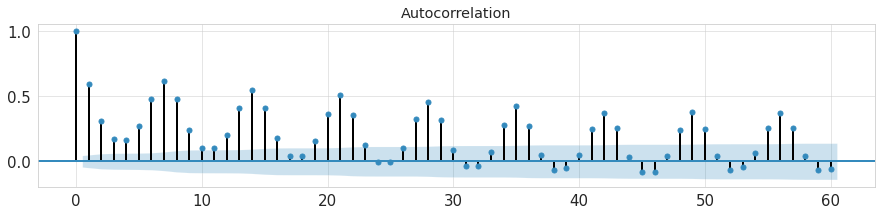

In [5]:
fig, ax = plt.subplots(figsize=(15, 3))
plot_acf(data['demand'].tolist(), lags=60, ax=ax);

RMSE for Simple Exponential Smoothing: 32.9815


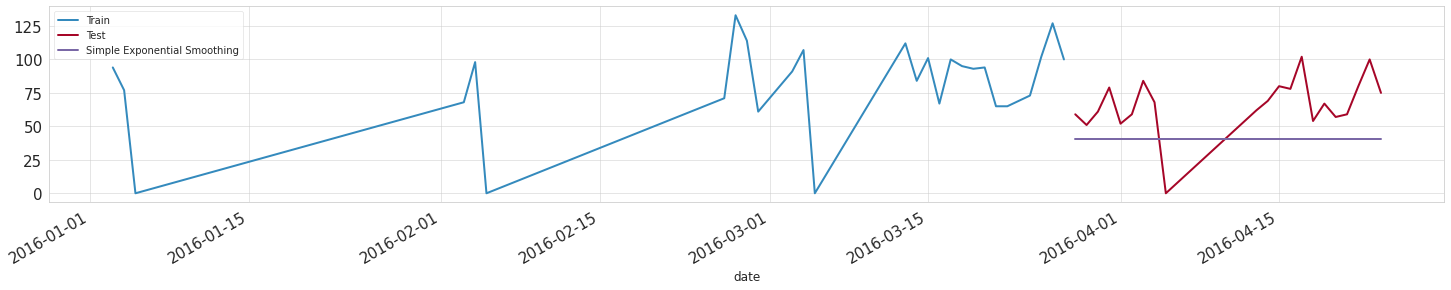

In [6]:
t0 = time.time()
model_name='Simple Exponential Smoothing'
span = 7
alpha = 2/(span+1)
#train
simpleExpSmooth_model = SimpleExpSmoothing(train['demand']).fit(smoothing_level=alpha,optimized=False)
t1 = time.time()-t0
#predict
predictions[model_name] = simpleExpSmooth_model.forecast(21).values
#visualize
fig, ax = plt.subplots(figsize=(25,4))
train[-28:].plot(x='date',y='demand',label='Train',ax=ax)
test.plot(x='date',y='demand',label='Test',ax=ax);
predictions.plot(x='date',y=model_name,label=model_name,ax=ax);
#evaluate
score = np.sqrt(mean_squared_error(predictions[model_name].values, test['demand']))
print('RMSE for {}: {:.4f}'.format(model_name,score))
stats = stats.append({'Model Name':model_name, 'Execution Time':t1, 'RMSE':score},ignore_index=True)

RMSE for Double Exponential Smoothing: 20.4344


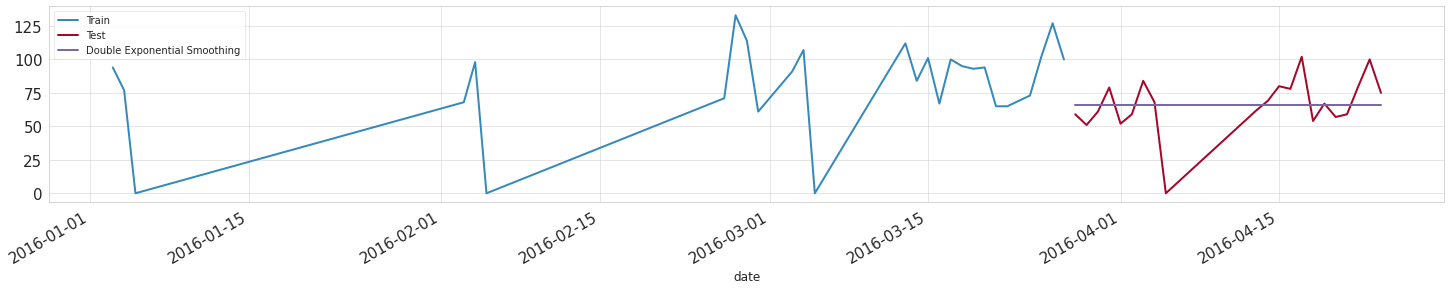

In [7]:
t0 = time.time()
model_name='Double Exponential Smoothing'
#train
doubleExpSmooth_model = ExponentialSmoothing(train['demand'],trend='add',seasonal_periods=7).fit()
t1 = time.time()-t0
#predict
predictions[model_name] = doubleExpSmooth_model.forecast(21).values
#visualize
fig, ax = plt.subplots(figsize=(25,4))
train[-28:].plot(x='date',y='demand',label='Train',ax=ax)
test.plot(x='date',y='demand',label='Test',ax=ax);
predictions.plot(x='date',y=model_name,label=model_name,ax=ax);
#evaluate
score = np.sqrt(mean_squared_error(predictions[model_name].values, test['demand']))
print('RMSE for {}: {:.4f}'.format(model_name,score))

stats = stats.append({'Model Name':model_name, 'Execution Time':t1, 'RMSE':score},ignore_index=True)

RMSE for Triple Exponential Smoothing: 31.3412


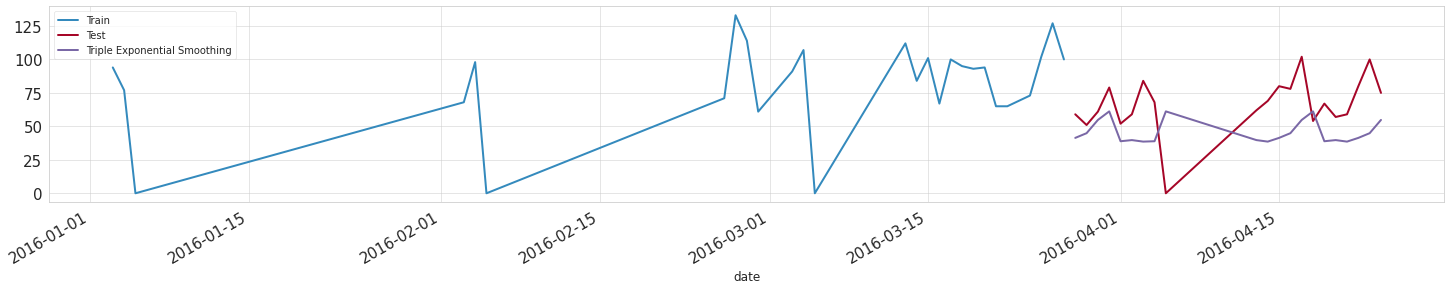

In [8]:
t0 = time.time()
model_name='Triple Exponential Smoothing'
#train
tripleExpSmooth_model = ExponentialSmoothing(train['demand'],trend='add',seasonal='add',seasonal_periods=7).fit()
t1 = time.time()-t0
#predict
predictions[model_name] = tripleExpSmooth_model.forecast(21).values

#visualize
fig, ax = plt.subplots(figsize=(25,4))
train[-28:].plot(x='date',y='demand',label='Train',ax=ax)
test.plot(x='date',y='demand',label='Test',ax=ax);
predictions.plot(x='date',y=model_name,label=model_name,ax=ax);
#evaluate
score = np.sqrt(mean_squared_error(predictions[model_name].values, test['demand']))
print('RMSE for {}: {:.4f}'.format(model_name,score))

stats = stats.append({'Model Name':model_name, 'Execution Time':t1, 'RMSE':score},ignore_index=True)


In [9]:
t0 = time.time()
model_name='ARIMA'
arima_model = auto_arima(train['demand'], start_p=0, start_q=0,
                          max_p=14, max_q=3,
                          seasonal=False,
                          d=None, trace=True,random_state=2020,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)
arima_model.summary() 

Performing stepwise search to minimize aic
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=17970.101, BIC=17981.161, Time=0.154 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=17928.466, BIC=17945.056, Time=0.090 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=17692.743, BIC=17709.332, Time=0.656 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=17968.107, BIC=17973.637, Time=0.058 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=17401.941, BIC=17424.061, Time=1.574 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=17318.510, BIC=17346.160, Time=2.062 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=17850.122, BIC=17872.242, Time=0.310 seconds
Fit ARIMA(3,1,1)x(0,0,0,0) [intercept=True]; AIC=17243.957, BIC=17277.136, Time=1.840 seconds
Fit ARIMA(3,1,0)x(0,0,0,0) [intercept=True]; AIC=17737.364, BIC=17765.014, Time=0.383 seconds
Fit ARIMA(4,1,1)x(0,0,0,0) [intercept=True]; AIC=17168.406, BIC=17207.116, Time=2.628 seconds
Fit ARIMA(4,1,0)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1864
Model:               SARIMAX(5, 1, 3)   Log Likelihood               -8399.012
Date:                Fri, 29 May 2020   AIC                          16818.025
Time:                        14:20:16   BIC                          16873.324
Sample:                             0   HQIC                         16838.402
                               - 1864                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0109      0.029     -0.372      0.710      -0.069       0.047
ar.L1          1.4688      0.024     60.887      0.000       1.422       1.516
ar.L2         -1.3044      0.035    -36.838      0.000      -1.374      -1.235
ar.L3          0.3974      0.047      8.523      0.000       0.306       0.489
ar.L4         -0.1974      0.040     -4.988      0.000      -0.275      -0.120
ar.L5          0.1344      0.027      4.952      0.000       0.081       0.188
ma.L1         -2.1385      0.016   -129.899      0.000      -2.171      -2.106
ma.L2          2.0614      0.023     89.076      0.000       2.016       2.107
ma.L3         -0.8727      0.014    -60.515      0.000      -0.901      -0.844
sigma2       496.5921     10.234     48.526      0.000     476.535     516.649
===================================================================================
Ljung-Box (Q):                      226.50   Jarque-Bera (JB):              2302.89
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.17   Skew:                            -0.61
Prob(H) (two-sided):                  0.06   Kurtosis:                         8.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

RMSE for ARIMA: 21.1751


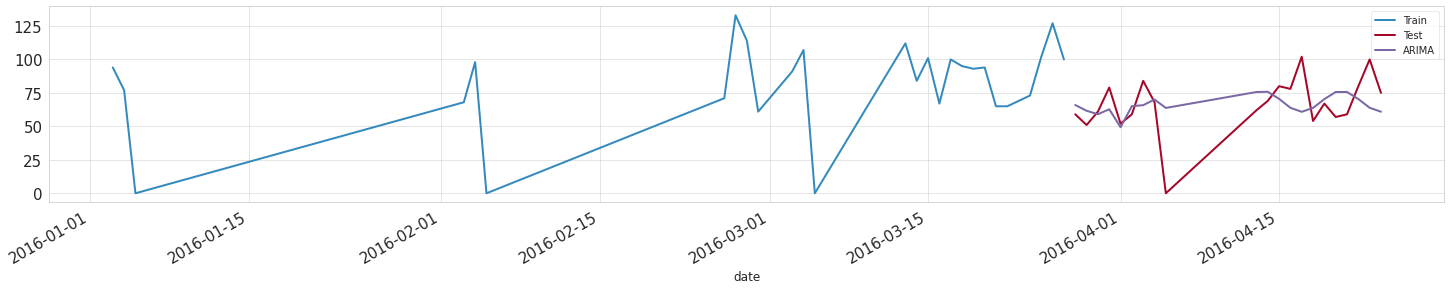

In [10]:
#train
arima_model.fit(train['demand'])
t1 = time.time()-t0
#predict
predictions[model_name] = arima_model.predict(n_periods=21)
#visualize
fig, ax = plt.subplots(figsize=(25,4))
train[-28:].plot(x='date',y='demand',label='Train',ax=ax)
test.plot(x='date',y='demand',label='Test',ax=ax);
predictions.plot(x='date',y=model_name,label=model_name,ax=ax);
#evaluate
score = np.sqrt(mean_squared_error(predictions[model_name].values, test['demand']))
print('RMSE for {}: {:.4f}'.format(model_name,score))

stats = stats.append({'Model Name':model_name, 'Execution Time':t1, 'RMSE':score},ignore_index=True)

In [11]:
t0 = time.time()
model_name='SARIMA'
sarima_model = auto_arima(train['demand'], start_p=0, start_q=0,
                          max_p=14, max_q=3,
                          seasonal=True, m=7,
                          d=None, trace=True,random_state=2020,
                          out_of_sample_size=21,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)
sarima_model.summary()

Performing stepwise search to minimize aic
Fit ARIMA(0,1,0)x(1,0,1,7) [intercept=True]; AIC=17338.236, BIC=17360.355, Time=4.488 seconds
Fit ARIMA(0,1,0)x(0,0,0,7) [intercept=True]; AIC=17970.101, BIC=17981.161, Time=0.150 seconds
Fit ARIMA(1,1,0)x(1,0,0,7) [intercept=True]; AIC=17582.797, BIC=17604.916, Time=1.925 seconds
Fit ARIMA(0,1,1)x(0,0,1,7) [intercept=True]; AIC=17421.590, BIC=17443.710, Time=2.539 seconds
Fit ARIMA(0,1,0)x(0,0,0,7) [intercept=False]; AIC=17968.107, BIC=17973.637, Time=0.096 seconds
Fit ARIMA(0,1,0)x(0,0,1,7) [intercept=True]; AIC=17815.447, BIC=17832.037, Time=1.480 seconds
Fit ARIMA(0,1,0)x(1,0,0,7) [intercept=True]; AIC=17738.901, BIC=17755.491, Time=1.156 seconds
Fit ARIMA(0,1,0)x(2,0,1,7) [intercept=True]; AIC=17335.771, BIC=17363.420, Time=10.060 seconds
Near non-invertible roots for order (0, 1, 0)(2, 0, 1, 7); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA(0,1,0)x(1,0,2,7) [intercept=True]; 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1864
Model:             SARIMAX(0, 1, 3)x(1, 0, [1], 7)   Log Likelihood               -8335.531
Date:                             Fri, 29 May 2020   AIC                          16685.063
Time:                                     14:27:36   BIC                          16723.772
Sample:                                          0   HQIC                         16699.327
                                            - 1864                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.002      0.105      0.916      -0.003       0.003
ma.L1         -0.6387      0.012    -52.020      0.000      -0.663      -0.615
ma.L2         -0.1722      0.020     -8.747      0.000      -0.211      -0.134
ma.L3         -0.0614      0.019     -3.300      0.001      -0.098      -0.025
ar.S.L7        0.9973      0.001    774.676      0.000       0.995       1.000
ma.S.L7       -0.9564      0.009   -109.906      0.000      -0.973      -0.939
sigma2       434.4613      7.633     56.922      0.000     419.502     449.421
===================================================================================
Ljung-Box (Q):                       78.91   Jarque-Bera (JB):              5411.76
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.29   Skew:                            -0.98
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

RMSE for SARIMA: 23.0584


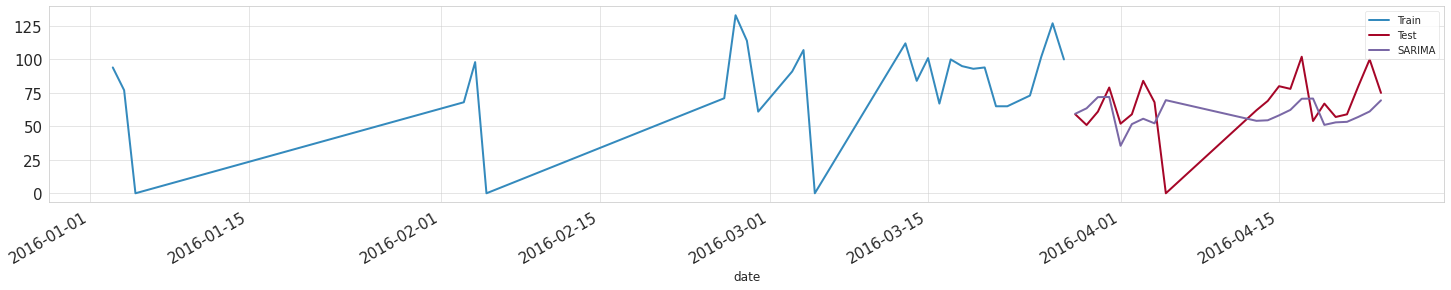

In [15]:
#train
sarima_model.fit(train['demand'])
t1 = time.time()-t0
#predict
predictions[model_name] = sarima_model.predict(n_periods=21)
#visualize
fig, ax = plt.subplots(figsize=(25,4))
train[-28:].plot(x='date',y='demand',label='Train',ax=ax)
test.plot(x='date',y='demand',label='Test',ax=ax);
predictions.plot(x='date',y=model_name,label=model_name,ax=ax);
#evaluate
score = np.sqrt(mean_squared_error(predictions[model_name].values, test['demand']))
print('RMSE for {}: {:.4f}'.format(model_name,score))

stats = stats.append({'Model Name':model_name, 'Execution Time':t1, 'RMSE':score},ignore_index=True)


In [16]:
t0 = time.time()
model_name='SARIMAX'
sarimax_model = auto_arima(train['demand'], start_p=0, start_q=0,
                          max_p=14, max_q=3,
                          seasonal=True, m=7,
                          exogenous = train[['sell_price']].values,
                          d=None, trace=True,random_state=2020,
                          out_of_sample_size=21,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)
sarimax_model.summary() 

Performing stepwise search to minimize aic
Fit ARIMA(0,1,0)x(1,0,1,7) [intercept=True]; AIC=17338.242, BIC=17365.892, Time=4.489 seconds
Fit ARIMA(0,1,0)x(0,0,0,7) [intercept=True]; AIC=17971.836, BIC=17988.425, Time=0.167 seconds
Fit ARIMA(1,1,0)x(1,0,0,7) [intercept=True]; AIC=17583.437, BIC=17611.087, Time=2.077 seconds
Fit ARIMA(0,1,1)x(0,0,1,7) [intercept=True]; AIC=17424.389, BIC=17452.038, Time=2.617 seconds
Fit ARIMA(0,1,0)x(0,0,0,7) [intercept=False]; AIC=17969.839, BIC=17980.899, Time=0.369 seconds
Fit ARIMA(0,1,0)x(0,0,1,7) [intercept=True]; AIC=17816.578, BIC=17838.697, Time=1.541 seconds
Fit ARIMA(0,1,0)x(1,0,0,7) [intercept=True]; AIC=17739.589, BIC=17761.709, Time=1.348 seconds
Fit ARIMA(0,1,0)x(2,0,1,7) [intercept=True]; AIC=17335.759, BIC=17368.939, Time=10.070 seconds
Near non-invertible roots for order (0, 1, 0)(2, 0, 1, 7); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA(0,1,0)x(1,0,2,7) [intercept=True]; 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1864
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -8336.408
Date:                           Fri, 29 May 2020   AIC                          16686.816
Time:                                   07:43:14   BIC                          16725.526
Sample:                                        0   HQIC                         16701.081
                                          - 1864                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -2.648e-05      0.001     -0.040      0.968      -0.001       0.001
x1          -109.9474     25.367     -4.334      0.000    -159.665     -60.229
ar.L1          0.2826      0.017     16.715      0.000       0.249       0.316
ma.L1         -0.9062      0.011    -79.969      0.000      -0.928      -0.884
ar.S.L7        0.9985      0.001   1203.803      0.000       0.997       1.000
ma.S.L7       -0.9703      0.007   -133.885      0.000      -0.984      -0.956
sigma2       435.5977      7.750     56.208      0.000     420.408     450.787
===================================================================================
Ljung-Box (Q):                       95.51   Jarque-Bera (JB):              5060.64
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.27   Skew:                            -0.92
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

RMSE for SARIMAX: 26.2055


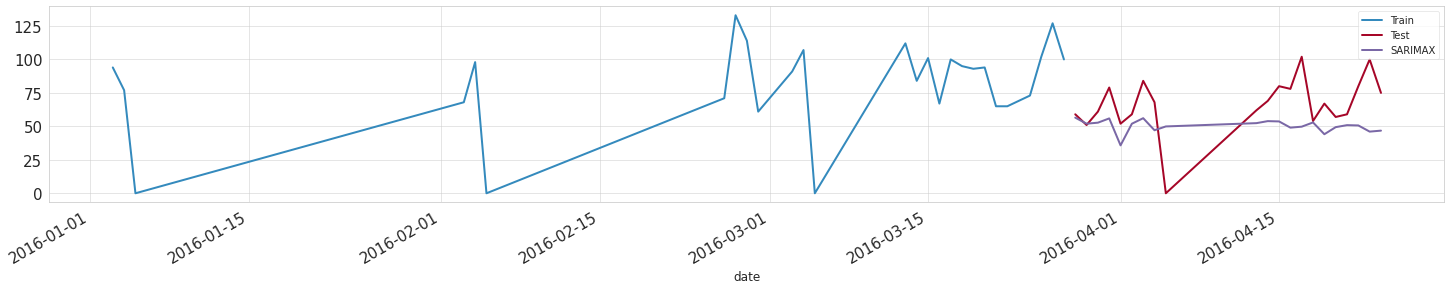

In [17]:
#train
sarimax_model.fit(train['demand'])
t1 = time.time()-t0
#predict
predictions[model_name] = sarimax_model.predict(n_periods=21)
#visualize
fig, ax = plt.subplots(figsize=(25,4))
train[-28:].plot(x='date',y='demand',label='Train',ax=ax)
test.plot(x='date',y='demand',label='Test',ax=ax);
predictions.plot(x='date',y=model_name,label=model_name,ax=ax);
#evaluate
score = np.sqrt(mean_squared_error(predictions[model_name].values, test['demand']))
print('RMSE for {}: {:.4f}'.format(model_name,score))

stats = stats.append({'Model Name':model_name, 'Execution Time':t1, 'RMSE':score},ignore_index=True)
